# Collisional Ionization Equilibrium of H and He

Example of using `pism` to solve for collisional ionization equilibrium (CIE) for a hydrogen-helium mixture and plot the ionization states as a function of temperature.

In [20]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import sympy as sp

# Simple processes
A simple process is defined by a single reaction, with a specified rate.

Let's inspect the structure of a single process, the gas-phase recombination of H+: `H+ + e- -> H + hν` 

In [21]:
from pism.processes import CollisionalIonization, GasPhaseRecombination

process = GasPhaseRecombination("H+")
print(f"Name: {process.name}")
print(f"Heating rate coefficient: {process.heat_rate_coefficient}")
print(f"Heating rate per cm^-3: {process.heat}"),
print(f"Rate coefficient: {process.rate_coefficient}")
print(f"Recombination rate per cm^-3: {process.rate}")
print(f"RHS of e- number density equation: {process.network["e-"]}")

Name: Gas-phase recombination of H+
Heating rate coefficient: -3.46353238381543e-26*T**0.3/(6.30957344480194e-5*T**0.7 + 1)
Heating rate per cm^-3: -3.46353238381543e-26*T**0.3*n_H+*n_e-/(6.30957344480194e-5*T**0.7 + 1)
Rate coefficient: 3.34410023264938e-10/(T**0.7*(6.30957344480194e-5*T**0.7 + 1))
Recombination rate per cm^-3: 3.34410023264938e-10*n_H+*n_e-/(T**0.7*(6.30957344480194e-5*T**0.7 + 1))
RHS of e- number density equation: -3.34410023264938e-10*n_H+*n_e-/(T**0.7*(6.30957344480194e-5*T**0.7 + 1))


Note that all symbolic representations assume CGS units as is standard in ISM physics.

## Composing processes
Now let's define our full network as a sum of simple processes

In [22]:
processes = [CollisionalIonization(s) for s in ("H", "He", "He+")] + [GasPhaseRecombination(i) for i in ("H+", "He+", "He++")]
#processes = [CollisionalIonization(s) for s in ("H",)] + [GasPhaseRecombination(i) for i in ("H+",)]

system = sum(processes)

Summed processes keep track of all subprocesses, e.g. the total net heating rate is:

In [23]:
system.heat

-1.5e-10*n_He+*n_e-/T**0.3647 - 3.46353238381543e-26*T**0.3*n_H+*n_e-/(6.30957344480194e-5*T**0.7 + 1) - 1.38541295352617e-25*T**0.3*n_He++*n_e-/(6.30957344480194e-5*T**0.7 + 1) + 1.2746917300104e-21*sqrt(T)*n_H*n_e-*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 9.37661057635428e-22*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 4.9524176975855e-22*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1)

Summing processes also sums all chemical and gas/dust cooling/heating rates. 

In [24]:
system.print_network_equations()

dn_He++/dt = n_e-*(5.68e-9*T**1.2*n_He+*(6.30957344480194e-5*T**0.7 + 1) - 1.33764009305975e-9*n_He++*(sqrt(10)*sqrt(T) + 1000)*exp(631515/T))*exp(-631515/T)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)*(sqrt(10)*sqrt(T) + 1000))
dn_He/dt = n_e-*(-2.38e-8*T**2.6353*n_He*exp(564000.0/T) + n_He+*(sqrt(10)*sqrt(T) + 1000)*(T**0.6353*(0.0019*exp(94000.0/T) + 0.00057) + 1.5e-10*T**1.5*exp(564000.0/T))*exp(285335.4/T))*exp(-849335.4/T)/(T**2.1353*(sqrt(10)*sqrt(T) + 1000))
dn_H/dt = n_e-*(-5.85e-8*T**1.2*n_H*(6.30957344480194e-5*T**0.7 + 1) + 3.34410023264938e-10*n_H+*(sqrt(10)*sqrt(T) + 1000)*exp(157809.1/T))*exp(-157809.1/T)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)*(sqrt(10)*sqrt(T) + 1000))
dn_e-/dt = n_e-*(-T**0.7*n_He+*(6.30957344480194e-5*T**0.7 + 1)*(sqrt(10)*sqrt(T) + 1000)*(T**0.6353*(0.0019*exp(94000.0/T) + 0.00057) + 1.5e-10*T**1.5*exp(564000.0/T))*exp(1074659.5/T) - T**2.1353*(3.34410023264938e-10*n_H+ + 1.33764009305975e-9*n_He++)*(sqrt(10)*sqrt(T) + 1000)*exp(1638659.5/T) + 5.85e-8

## Solving ionization equilibrium

Today we would like to solve for ionization equilibrium given a temperature `T`. That means finding the chemical abundances that set this thing to 0:

In [25]:
system.network["e-"]

-3.34410023264938e-10*n_H+*n_e-/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) - 1.33764009305975e-9*n_He++*n_e-/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) + 5.85e-11*sqrt(T)*n_H*n_e-*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 2.38e-11*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 5.68e-12*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_He+*n_e-*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.5e-10/T**0.6353)

The full network above had 6 equations, but we may introduce two known quantities: the total H number density and the helium mass fraction Y.

`n_Htot = n_H + n_H+`

`n_He + n_He+ + n_He++ = Y/(4-Y) n_Htot`

We may also invoke conservation of electrons:

`n_e- = n_H+ + n_He+ + 2 n_He++`

This allows us to eliminate 3 variables from the system.

In [31]:
Y = sp.symbols("Y")
nHtot = sp.symbols("n_Htot")

substitutions = {
                "n_e-": sp.symbols("n_H+") + sp.symbols("n_He+")  + sp.symbols("n_He++"),
                "n_H+": sp.symbols("n_Htot") - sp.symbols("n_H"),
                 "n_He++": Y/(4-Y) * nHtot - sp.symbols("n_He") - sp.symbols("n_He+"),                  
}

for species in system.network:
    for s in substitutions:
        system.network[species] = system.network[species].subs(s, substitutions[s])

system.network

defaultdict(int,
            {'He++': -1.33764009305975e-9*(Y*n_Htot/(4 - Y) - n_He - n_He+)*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) + 5.68e-12*sqrt(T)*n_He+*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1),
             'He': -2.38e-11*sqrt(T)*n_He*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + n_He+*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.5e-10/T**0.6353)*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot),
             'H': 3.34410023264938e-10*(-n_H + n_Htot)*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) - 5.85e-11*sqrt(T)*n_H*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1),
             'e-': -3.34410023264938e-10*(-n_H + n_Htot)*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) - 1.33764009305975e-9*(Y*n_Htot/(4 - Y) - n_He - n_He+)*(Y*n_Htot/(4 

### Symbolic Jacobian
For our remaining unknowns we can define a Jacbon w.r.t. those quantities:

In [33]:
unknowns = sp.symbols("n_H n_He n_He+")
#unknowns = sp.symbols("n_H n_e-")
knowns = sp.symbols("T n_Htot Y")

jac = []
reduced_network = []
for species, rhs in system.network.items(): 
    if f"n_{species}" in substitutions: continue
    reduced_network.append(rhs)
    jac.append([sp.diff(rhs, u) for u in unknowns])

sp.Matrix(jac)

Matrix([
[                                                                                                                                                                                                             2.38e-11*sqrt(T)*n_He*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_He+*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.5e-10/T**0.6353),                                                                                                                                                                                                                                                                                 2.38e-11*sqrt(T)*n_He*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 2.38e-11*sqrt(T)*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_He+*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.5e-10/T**0.6353),                                                                                                   

## Numerical solution

To solve the system numerically we may use Newton iterations:

$$ \mathbf{X}_{n+1} = \mathbf{X}_{\rm n} - \mathbf{J}^{-1}\left(\mathbf{X}_{\rm n}\right) \mathbf{f(\mathbf{X}_{\rm n})}$$

where $\mathbf{X}$ is the vector of unknowns, $\mathbf{f}(\mathbf{X})$ is the vector of RHS in the chemical rates we wish to solve = 0, and $J$ is the Jacobian of $f(X)$.

(0.5, 1e-05, 1e-05)
[7.49660071e-01 3.19544583e-02 4.99463832e-06]
[8.74489814e-01 4.79266499e-02 2.49196336e-06]
[9.36904100e-01 5.59126708e-02 1.24063762e-06]
[9.68110071e-01 5.99055313e-02 6.14998243e-07]
[9.83710713e-01 6.19016617e-02 3.02225529e-07]
[9.91506351e-01 6.28991277e-02 1.45933072e-07]
[9.95394822e-01 6.33966646e-02 6.79742495e-08]
[9.97320519e-01 6.36430610e-02 2.93665233e-08]
[9.98247498e-01 6.37616697e-02 1.07817823e-08]


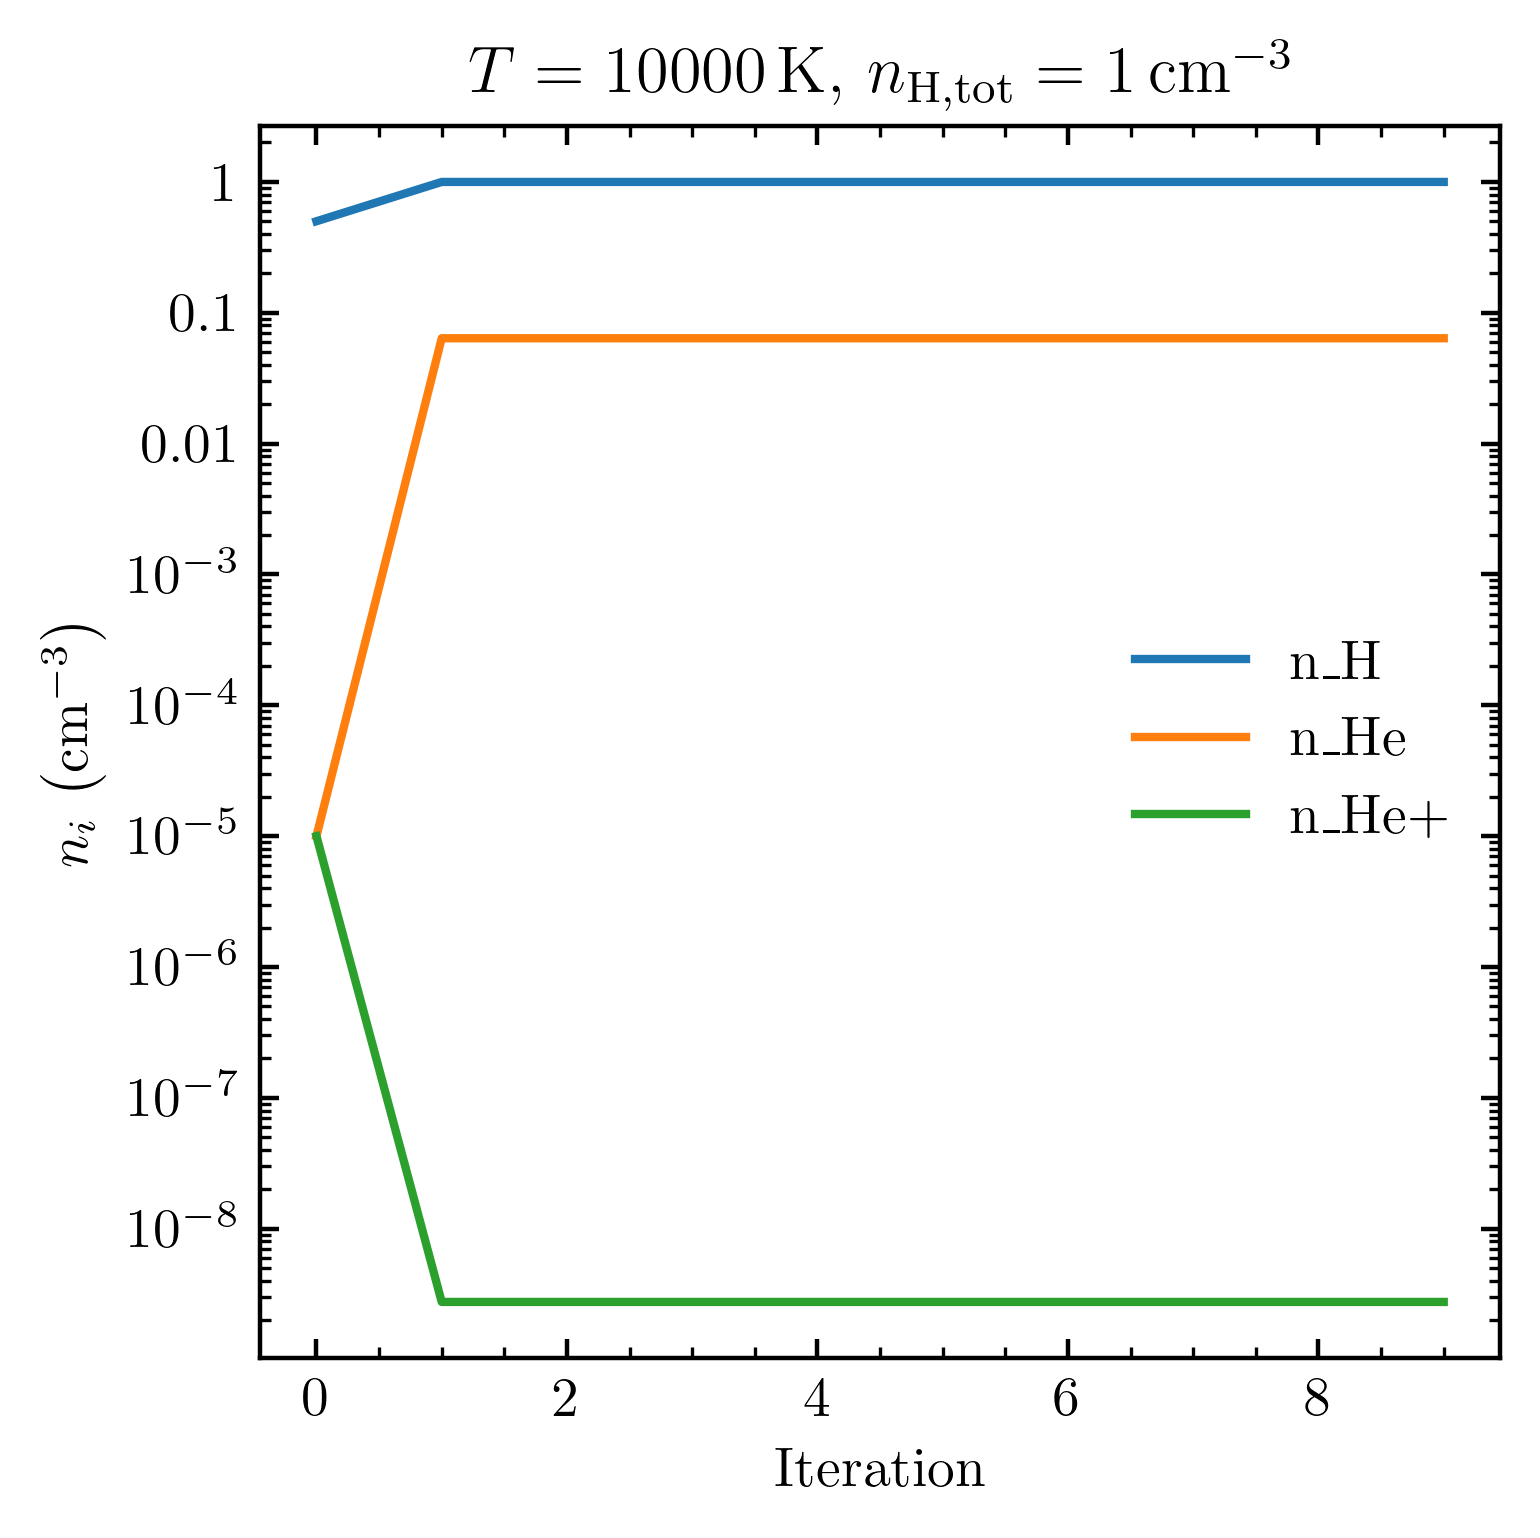

In [47]:
from scipy.optimize import fsolve

x0 = (0.5,1e-5, 1e-5)  #1e-6,1e-6,0.5) # n_H n_He n_He+ n_e- initial guess
Tval = 10**4
knownvals = (Tval, 1, 0.24)

func = sp.lambdify(unknowns+knowns, reduced_network)
jacfunc =  sp.lambdify(unknowns + knowns, jac)

def f_numerical(X):
    arg = tuple(X) + knownvals
    return func(*arg)

def jac_numerical(X):
    arg = tuple(X) + knownvals
    return jacfunc(*arg)

X = x0
X_iter = []
for i in range(10):
    print(X)
    X_iter.append(X)
    J = jac_numerical(X)
    f = f_numerical(X)
    dx = -np.linalg.solve(J, f)
    X += dx

plt.title(rf"$T={Tval}\rm\,K$" + r", $n_{\rm H,tot}=1\,\rm cm^{-3}$")
plt.plot(X_iter,label=unknowns); plt.yscale('log'); plt.xlabel("Iteration"); plt.ylabel(r"$n_i\,\left(\rm cm^{-3}\right)$"); plt.legend()